In [24]:
import os
import re
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# NLTK downloads
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab', quiet=True)

# Ensure save folder
os.makedirs("./bert-aspect-sentiment", exist_ok=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kostis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kostis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kostis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device for evaluation:", device)

Using device for evaluation: cpu


In [27]:
CSV_PATH = r"C:\Users\Kostis\Desktop\glassdoor_reviews.csv"
df = pd.read_csv(CSV_PATH, on_bad_lines='skip', engine='python')

display(df.head())
display(df.describe())

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,2,4.0,3.0,NaN,2.0,3.0,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,5,2.0,3.0,NaN,2.0,2.0,3.0,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr..."


,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt
count,838566.000000,688672.000000,647193.000000,136066.000000,691065.000000,688484.000000,682690.000000
mean,3.655956,3.375735,3.590164,3.966612,3.461825,3.398109,3.176576
std,1.174684,1.305874,1.323280,1.190937,1.271295,1.218738,1.330720
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000
75%,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [32]:
df['date_review'] = pd.to_datetime(df['date_review'], errors='coerce')
for col in ['headline', 'pros', 'cons']:
    df[col] = df[col].fillna("")
df['text'] = df['headline'] + " " + df['pros'] + " " + df['cons']

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if (word not in stop_words) and (len(word) > 2)]
    return ' '.join(clean_tokens)

df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.len() > 0].copy()

display(df.head())
display(df.describe())

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,...,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,text,cleaned_text,word_count
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,2,4.0,3.0,NaN,2.0,...,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.","Young colleagues, poor micro management Very f...",young colleague poor micro management friendly...,17
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,...,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,"Excellent staff, poor salary Friendly, helpful...",excellent staff poor salary friendly helpful h...,21
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,...,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...","Low salary, bad micromanagement Easy to get th...",low salary bad micromanagement easy get job ev...,31
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,5,2.0,3.0,NaN,2.0,...,3.0,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,Over promised under delivered Nice staff to wo...,promised delivered nice staff work career prog...,8
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,...,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...","client reporting admin Easy to get the job, Ni...",client reporting admin easy get job nice colle...,30


,date_review,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,word_count
count,838507,838507.000000,688642.000000,647161.000000,136045.000000,691033.000000,688452.000000,682658.000000,838507.000000
mean,2018-01-30 13:49:24.232856832,3.655900,3.375697,3.590124,3.966518,3.461788,3.398081,3.176531,20.686137
min,2008-01-31 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2016-04-01 00:00:00,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,9.000000
50%,2018-08-22 00:00:00,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,13.000000
75%,2020-09-12 00:00:00,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,23.000000
max,2021-06-08 00:00:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1449.000000
std,NaN,1.174685,1.305867,1.323280,1.190940,1.271292,1.218730,1.330707,24.645418


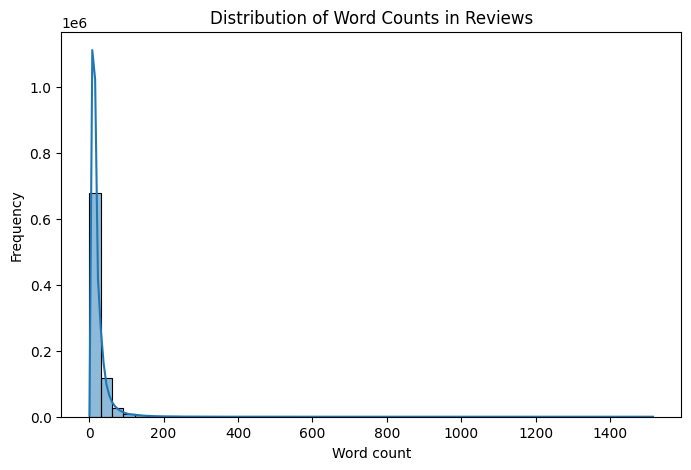

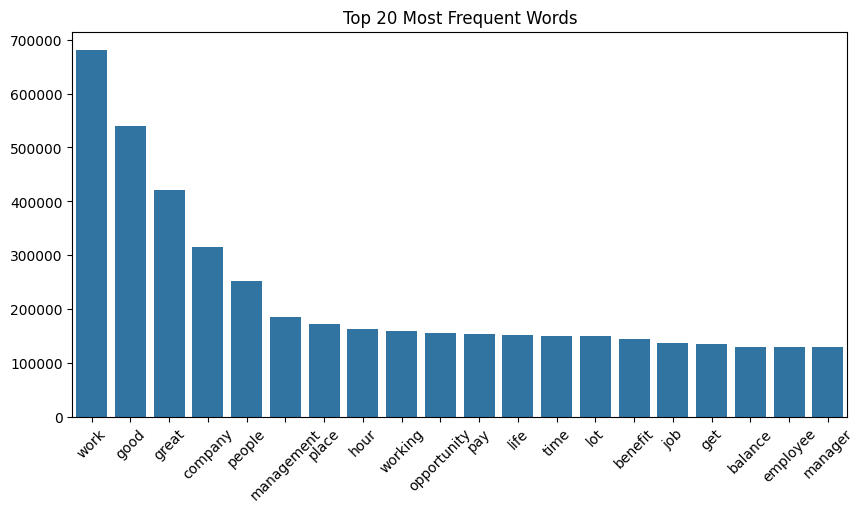

In [33]:
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts in Reviews")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

from collections import Counter
all_words = " ".join(df['cleaned_text']).split()
freq_words = Counter(all_words).most_common(20)
words, counts = zip(*freq_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

In [34]:
aspects = {
    'work_life_balance': ['work', 'life', 'balance', 'hour', 'time', 'flexible', 'schedule', 'overtime', 'working'],
    'culture_values': ['culture', 'value', 'environment', 'atmosphere', 'people', 'team', 'colleague', 'fun', 'staff'],
    'diversity_inclusion': ['diversity', 'inclusion', 'woman', 'minority', 'discrimination', 'equal', 'lgbtq'],
    'career_opp': ['career', 'opportunity', 'growth', 'advancement', 'promotion', 'develop', 'skill', 'training', 'experience'],
    'comp_benefits': ['pay', 'salary', 'compensation', 'benefit', 'bonus', 'insurance', 'health', '401k', 'money'],
    'senior_mgmt': ['management', 'manager', 'leadership', 'executive', 'ceo', 'boss', 'supervisor', 'director']
}
def find_aspect(sentence, aspect_keywords):
    words = sentence.split()
    for word in words:
        if word in aspect_keywords:
            return True
    return False

In [58]:
rows = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = row['cleaned_text']
    if pd.isna(text) or len(text.strip()) == 0:
        continue
    sents = sent_tokenize(text)
    for sent in sents:
        for aspect_name, keywords in aspects.items():
            if find_aspect(sent, keywords):
                rating = row.get(aspect_name, np.nan)
                if pd.isna(rating):
                    continue
                if rating >= 4.0:
                    sentiment = 'positive'
                elif rating <= 2.0:
                    sentiment = 'negative'
                else:
                    sentiment = 'neutral'
                rows.append({
                    'sentence': sent,
                    'aspect': aspect_name,
                    'sentiment': sentiment,
                    'date_review': row['date_review'],  
                    'firm': row['firm']                 
                })

aspect_df = pd.DataFrame(rows)
print("Aspect sentences:", len(aspect_df))
print(aspect_df['sentiment'].value_counts())

  0%|          | 0/838507 [00:00<?, ?it/s]

Aspect sentences: 1701955
sentiment
positive    867826
negative    453997
neutral     380132
Name: count, dtype: int64


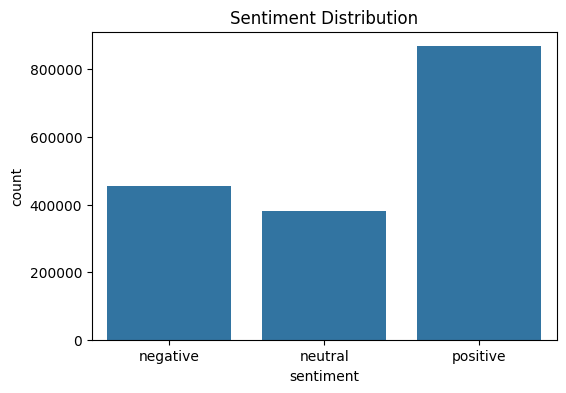

In [59]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=aspect_df, order=['negative','neutral','positive'])
plt.title("Sentiment Distribution")
plt.show()

In [61]:
SAMPLE_SIZE = 20000 
aspect_df = aspect_df.sample(SAMPLE_SIZE, random_state=42)
print("Sampled dataset size:", len(aspect_df))
print(aspect_df['sentiment'].value_counts())

Sampled dataset size: 20000
sentiment
positive    10149
negative     5358
neutral      4493
Name: count, dtype: int64


In [62]:
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
aspect_df['label'] = aspect_df['sentiment'].map(label2id)

train_df, temp_df = train_test_split(aspect_df, test_size=0.2, random_state=42, stratify=aspect_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 16000, Val: 2000, Test: 2000


In [63]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))

max_length = 80

def tokenize_in_batches(texts, labels, batch_size=2000, max_length=128):
    all_input_ids, all_attention_masks, all_labels = [], [], []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        enc = tokenizer(
            batch_texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        
        all_input_ids.append(enc["input_ids"])
        all_attention_masks.append(enc["attention_mask"])
        all_labels.extend(batch_labels)
    
    input_ids = torch.cat(all_input_ids, dim=0)
    attention_masks = torch.cat(all_attention_masks, dim=0)
    labels = torch.tensor(all_labels)
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

train_dataset = tokenize_in_batches(train_df['sentence'].tolist(), train_df['label'].tolist())
val_dataset = tokenize_in_batches(val_df['sentence'].tolist(), val_df['label'].tolist())
test_dataset = tokenize_in_batches(test_df['sentence'].tolist(), test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

def compute_metrics(predictions, labels):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc}

def train_model(model, train_loader, val_loader, epochs=5, patience=2):
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model.to(device)
    best_f1 = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        
        model.train()
        total_loss = 0
        train_preds, train_labels = [], []
        for batch in tqdm(train_loader, desc="Training"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_preds.extend(outputs.logits.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        train_metrics = compute_metrics(np.array(train_preds), np.array(train_labels))

        
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                val_preds.extend(outputs.logits.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_metrics = compute_metrics(np.array(val_preds), np.array(val_labels))

        print(f"Train Loss: {total_loss / len(train_loader):.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Val Metrics: {val_metrics}")

       
        if val_metrics["f1"] > best_f1:
            best_f1 = val_metrics["f1"]
            patience_counter = 0
            torch.save(model.state_dict(), "./bert-aspect-sentiment/best_model.pth")
            print(">>> Best model saved!")
        else:
            patience_counter += 1
            print(f"No improvement. Patience counter = {patience_counter}")
            if patience_counter >= patience:
                print(">>> Early stopping triggered.")
                break

    return model


trained_model = train_model(model, train_loader, val_loader, epochs=5, patience=2)

Using device: cpu

Epoch 1/5


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\Kostis\PycharmProjects\myFirstProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Train Loss: 0.9195
Train Metrics: {'precision': 0.5171823429603819, 'recall': 0.588125, 'f1': 0.5098629760689716, 'accuracy': 0.588125}
Val Metrics: {'precision': 0.4598930388674778, 'recall': 0.59, 'f1': 0.5024026684285579, 'accuracy': 0.59}
>>> Best model saved!

Epoch 2/5


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.8461
Train Metrics: {'precision': 0.5553027839954361, 'recall': 0.6258125, 'f1': 0.5524989269276409, 'accuracy': 0.6258125}
Val Metrics: {'precision': 0.5299482142594122, 'recall': 0.5845, 'f1': 0.5169098418160023, 'accuracy': 0.5845}
>>> Best model saved!

Epoch 3/5


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.7532
Train Metrics: {'precision': 0.6311054857663775, 'recall': 0.6699375, 'f1': 0.6337346778190835, 'accuracy': 0.6699375}
Val Metrics: {'precision': 0.5751874969918003, 'recall': 0.56, 'f1': 0.5660733446896086, 'accuracy': 0.56}
>>> Best model saved!

Epoch 4/5


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6247
Train Metrics: {'precision': 0.7146899300310491, 'recall': 0.731375, 'f1': 0.7190395845917452, 'accuracy': 0.731375}
Val Metrics: {'precision': 0.5498958700052808, 'recall': 0.558, 'f1': 0.5514760764165526, 'accuracy': 0.558}
No improvement. Patience counter = 1

Epoch 5/5


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4702
Train Metrics: {'precision': 0.8028673489575135, 'recall': 0.8068125, 'f1': 0.8041280715840612, 'accuracy': 0.8068125}
Val Metrics: {'precision': 0.5654789535740671, 'recall': 0.554, 'f1': 0.5584965622132974, 'accuracy': 0.554}
No improvement. Patience counter = 2
>>> Early stopping triggered.


In [65]:
def evaluate_model(model, data_loader, device):
    model.to(device)
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, y = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.extend(outputs.logits.cpu().numpy())
            labels.extend(y.cpu().numpy())
    return compute_metrics(np.array(preds), np.array(labels))

val_res = evaluate_model(trained_model, val_loader, device)
test_res = evaluate_model(trained_model, test_loader, device)

print("Val Results:", val_res)
print("Test Results:", test_res)


torch.save(trained_model.state_dict(), "./bert-aspect-sentiment/best_model.pth")
tokenizer.save_pretrained("./bert-aspect-sentiment/best_tokenizer")


Val Results: {'precision': 0.5654789535740671, 'recall': 0.554, 'f1': 0.5584965622132974, 'accuracy': 0.554}
Test Results: {'precision': 0.5557411496019599, 'recall': 0.5455, 'f1': 0.550097180244846, 'accuracy': 0.5455}


('./bert-aspect-sentiment/best_tokenizer\\tokenizer_config.json',
 './bert-aspect-sentiment/best_tokenizer\\special_tokens_map.json',
 './bert-aspect-sentiment/best_tokenizer\\vocab.txt',
 './bert-aspect-sentiment/best_tokenizer\\added_tokens.json',
 './bert-aspect-sentiment/best_tokenizer\\tokenizer.json')

In [77]:
def predict_sentiments(df, model, tokenizer, max_length, label2id):
    id2label = {v: k for k, v in label2id.items()}
    model.eval()
    preds = []

    for sent in tqdm(df['sentence'].tolist(), desc="Predicting sentiments"):
        enc = tokenizer(sent, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        if torch.cuda.is_available():
            enc = {k: v.cuda() for k, v in enc.items()}
            model.cuda()
        with torch.no_grad():
            out = model(**enc)
            probs = torch.nn.functional.softmax(out.logits, dim=1).cpu().numpy()[0]
            pred = int(np.argmax(probs))
            label = id2label[pred]
        preds.append(label)

    df = df.copy()
    df['predicted_sentiment'] = preds
    return df

pred_df = predict_sentiments(aspect_df, trained_model, tokenizer, max_length, label2id)

Πρόβλεψη sentiments με το εκπαιδευμένο μοντέλο...


Predicting sentiments:   0%|          | 0/20000 [00:00<?, ?it/s]

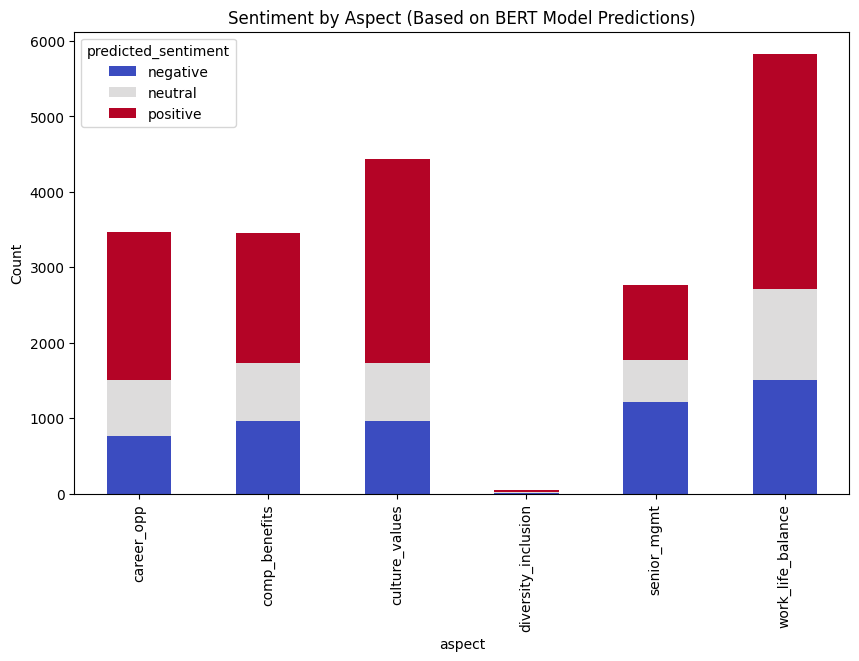

career_opp: Mixed feedback  (Pos 56.5%, Neg 21.9%) → Monitor
comp_benefits: Mixed feedback  (Pos 49.8%, Neg 27.9%) → Monitor
culture_values: Strong point  (60.8% ) → Continue investing
diversity_inclusion: Strong point  (61.7% ) → Continue investing
senior_mgmt: High negatives  (44.0%) → Immediate action 
work_life_balance: Mixed feedback  (Pos 53.5%, Neg 25.8%) → Monitor


In [84]:
aspect_summary = pred_df.groupby(['aspect','predicted_sentiment']).size().unstack(fill_value=0)


aspect_summary.plot(kind='bar', stacked=True, figsize=(10,6), colormap="coolwarm")
plt.title("Sentiment by Aspect (Based on BERT Model Predictions)")
plt.ylabel("Count")
plt.show()


aspect_perc = aspect_summary.div(aspect_summary.sum(axis=1), axis=0) * 100

recommendations = {}
for aspect in aspect_perc.index:
    
    pos = aspect_perc.loc[aspect, "positive"] if "positive" in aspect_perc.columns else 0
    neg = aspect_perc.loc[aspect, "negative"] if "negative" in aspect_perc.columns else 0
    neu = aspect_perc.loc[aspect, "neutral"] if "neutral" in aspect_perc.columns else 0

    if neg > 40:
        msg = f"{aspect}: High negatives  ({neg:.1f}%) → Immediate action "
    elif pos > 60:
        msg = f"{aspect}: Strong point  ({pos:.1f}% ) → Continue investing"
    else:
        msg = f"{aspect}: Mixed feedback  (Pos {pos:.1f}%, Neg {neg:.1f}%) → Monitor"
    recommendations[aspect] = msg
    print(msg)

Sentiment consistency: 61.02%
Παράδειγμα mismatch:
                                   headline  \
0  Young colleagues, poor micro management   
1             Excellent staff, poor salary   
2          Low salary, bad micromanagement   
3            Over promised under delivered   
4                   client reporting admin   

                                                pros  \
0  Very friendly and welcoming to new staff. Easy...   
1      Friendly, helpful and hard-working colleagues   
2  Easy to get the job even without experience in...   
3                            Nice staff to work with   
4              Easy to get the job, Nice colleagues.   

                                                cons  overall_rating  \
0    Poor salaries, poor training and communication.               2   
1  Poor salary which doesn't improve much with pr...               2   
2  Very low salary, poor working conditions, very...               1   
3           No career progression and salary i

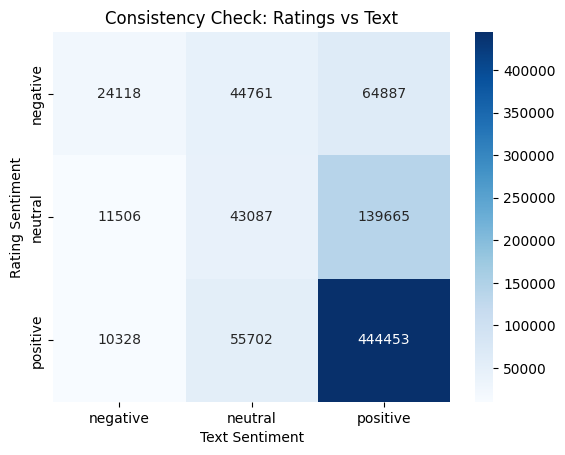

In [79]:
from textblob import TextBlob

def get_sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['text_sentiment'] = df['cleaned_text'].apply(get_sentiment_label)

def rating_to_label(r):
    if r >= 4: return 'positive'
    elif r <= 2: return 'negative'
    else: return 'neutral'

df['rating_label'] = df['overall_rating'].apply(rating_to_label)

consistency = (df['text_sentiment'] == df['rating_label']).mean()
print(f"Sentiment consistency: {consistency*100:.2f}%")

mismatches = df[df['text_sentiment'] != df['rating_label']]
print("mismatch example:\n", mismatches[['headline','pros','cons','overall_rating','text_sentiment','rating_label']].head())

conf_mat = pd.crosstab(df['rating_label'], df['text_sentiment'])
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Text Sentiment")
plt.ylabel("Rating Sentiment")
plt.title("Consistency Check: Ratings vs Text")
plt.show()

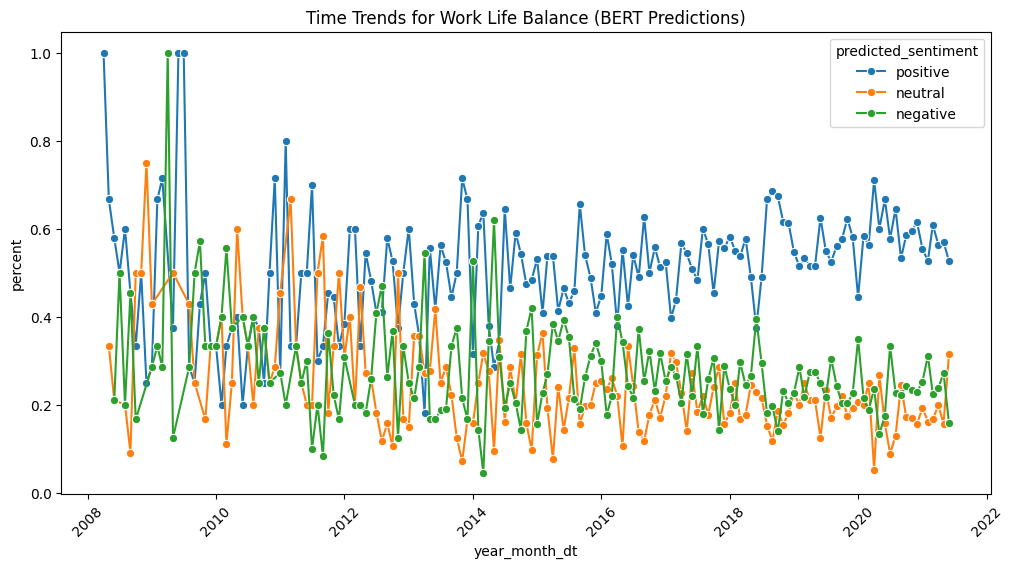

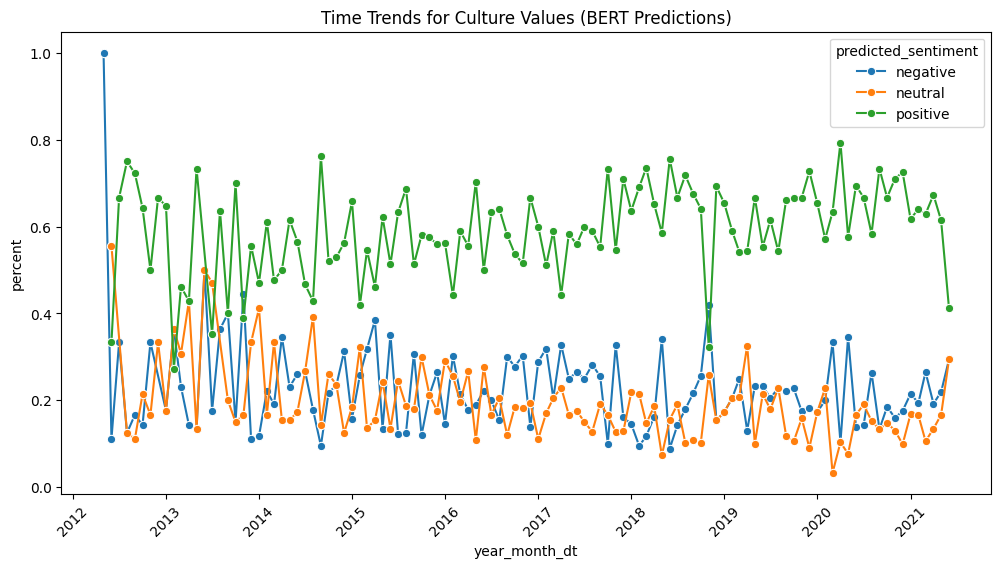

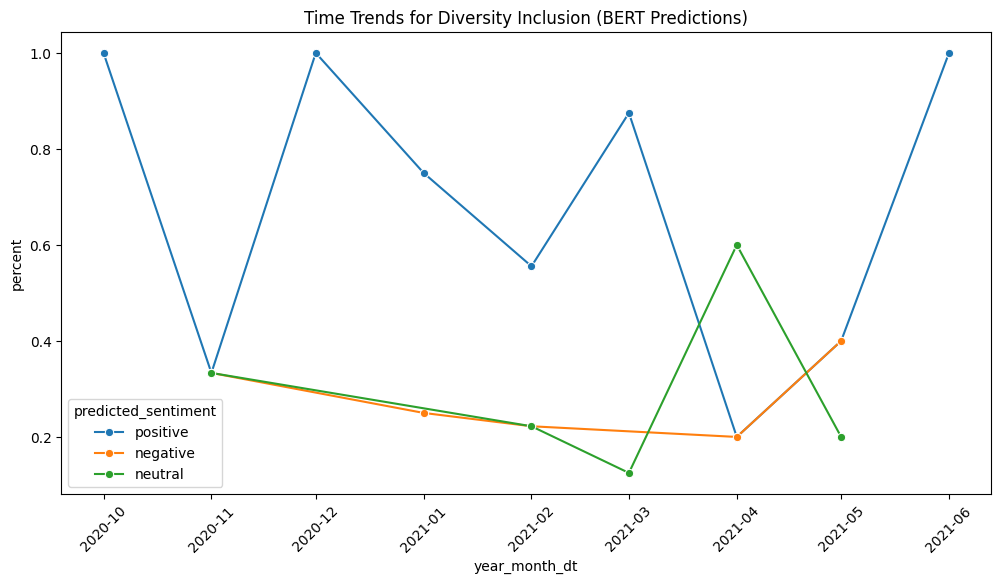

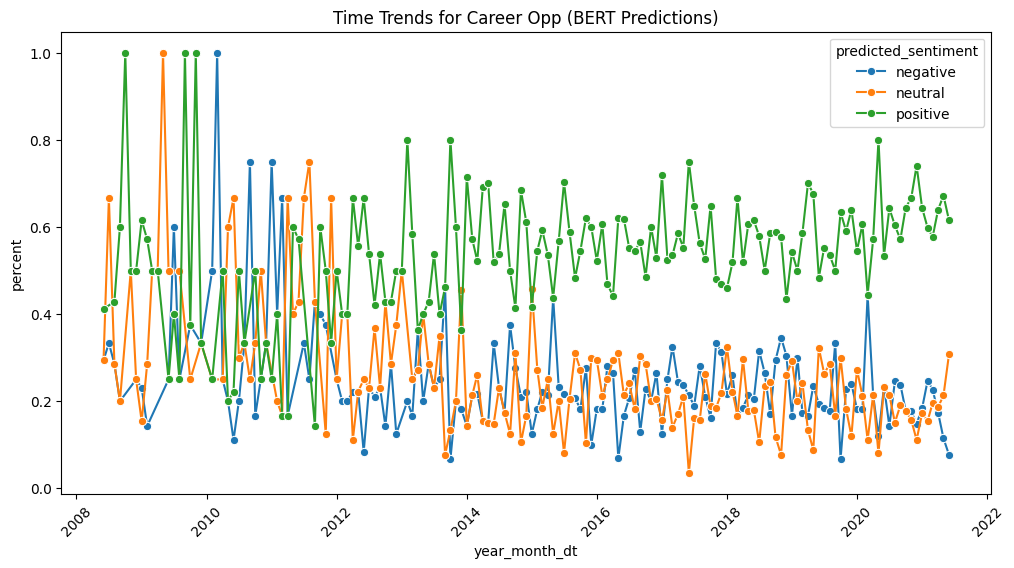

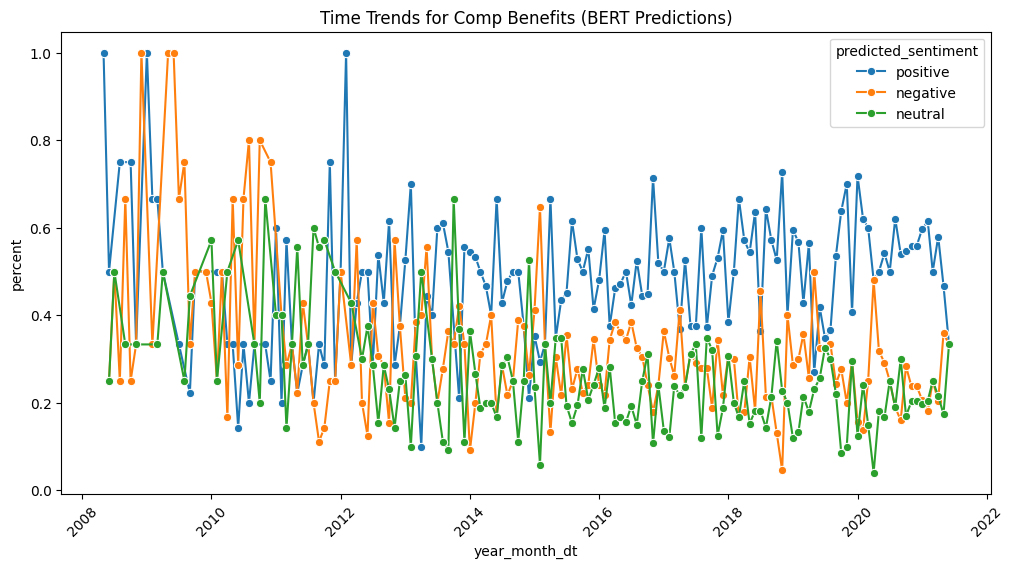

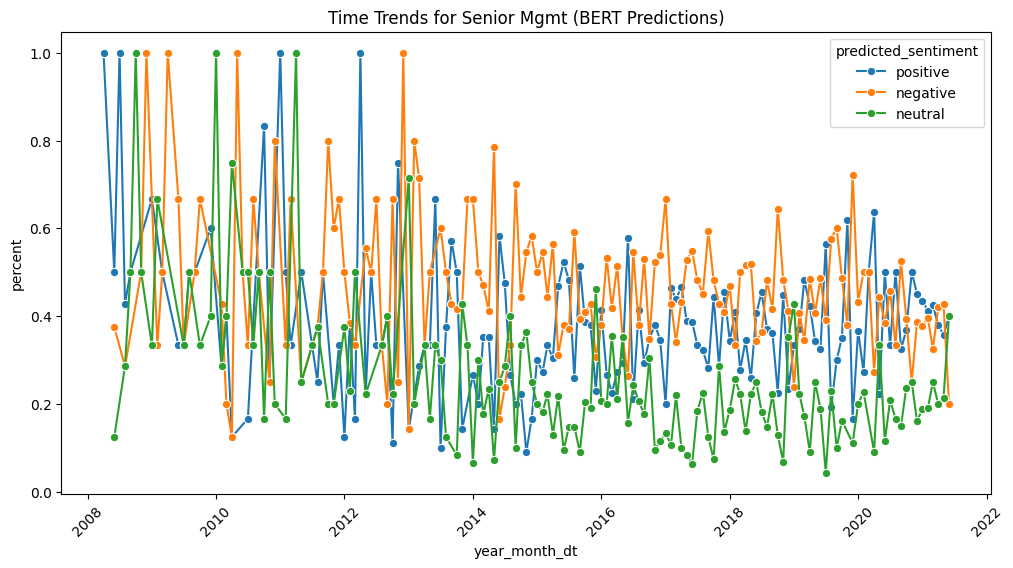

In [80]:
pred_df['year_month'] = pred_df['date_review'].dt.to_period('M')


time_trends = (pred_df
               .groupby(['year_month', 'aspect', 'predicted_sentiment'])
               .size()
               .reset_index(name='count'))


time_trends['percent'] = (time_trends.groupby(['year_month', 'aspect'])['count']
                          .transform(lambda x: x / x.sum()))


time_trends['year_month_dt'] = time_trends['year_month'].dt.to_timestamp()

aspects_list = list(aspects.keys())
for aspect in aspects_list:
    plt.figure(figsize=(12,6))
    sns.lineplot(data=time_trends[time_trends['aspect']==aspect],
                 x='year_month_dt', y='percent', hue='predicted_sentiment', marker="o")
    plt.title(f"Time Trends for {aspect.replace('_', ' ').title()} (BERT Predictions)")
    plt.xticks(rotation=45)
    plt.show()

In [85]:
risk_df = (pred_df.groupby('firm')['predicted_sentiment']
           .value_counts()
           .unstack(fill_value=0)
           .reset_index())


for col in ['negative', 'neutral', 'positive']:
    if col not in risk_df.columns:
        risk_df[col] = 0


risk_df['risk_score'] = risk_df['negative'] / (risk_df['positive'] + 1)


print("Top 10 risk companies:")
print(risk_df.sort_values('risk_score', ascending=False).head(10))

Top 10 risk companies:
predicted_sentiment                      firm  negative  neutral  positive  \
325                                 The-Range         9        0         0   
227                                     Mitie        17        1         2   
171                     ISS-Facility-Services        19        7         4   
205                                Link-Group        11        1         2   
92                           Creative-Support         6        0         1   
151                         HM-Prison-Service         3        2         0   
141                             Grange-Hotels         3        0         0   
275                            Rapport-London         3        0         0   
131                  Four-Seasons-Health-Care         8        0         2   
105                                 Debenhams        37       11        15   

predicted_sentiment  risk_score  
325                    9.000000  
227                    5.666667  
171             

In [82]:
def analyze_new_review_with_bert(review_text, model, tokenizer, aspects, max_length, label2id):
    model.eval()
    cleaned = clean_text(review_text)
    sents = sent_tokenize(cleaned)
    results = []
    for sent in sents:
        found_aspects = []
        for aspect_name, keywords in aspects.items():
            if find_aspect(sent, keywords):
                found_aspects.append(aspect_name)
        if not found_aspects:
            continue
        enc = tokenizer(sent, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        if torch.cuda.is_available():
            enc = {k: v.cuda() for k, v in enc.items()}
            model.cuda()
        with torch.no_grad():
            out = model(**enc)
            probs = torch.nn.functional.softmax(out.logits, dim=1).cpu().numpy()[0]
            pred = int(np.argmax(probs))
            label = {v: k for k, v in label2id.items()}[pred]
            prob = float(probs[pred])
        for asp in found_aspects:
            results.append({
                "sentence": sent,
                "aspect": asp,
                "pred_label": label,
                "pred_prob": prob
            })
    return pd.DataFrame(results)


example = "The management was poor but salary and benefits were great. The schedule is flexible though."
print(analyze_new_review_with_bert(example, trained_model, tokenizer, aspects, max_length, label2id))

                                            sentence             aspect  \
0  management poor salary benefit great schedule ...  work_life_balance   
1  management poor salary benefit great schedule ...      comp_benefits   
2  management poor salary benefit great schedule ...        senior_mgmt   

  pred_label  pred_prob  
0   negative   0.392567  
1   negative   0.392567  
2   negative   0.392567  
